<a href="https://colab.research.google.com/github/juancaalcaraz/practicaML/blob/main/AprendizageConjunto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Conjunto.
## El objetivo de los combinado de conjuntos es combinar diferentes clasificadores en un meta-clasificador que tenga un rendimiento de generalización mejor que cada clasificador por separado. Un enfoque para llevar esto a cabo es mediante el voto mayoritario(Ajustes de clase binaria) y el voto pluralista(Ajustes de multiclase). Esto significa simplemente que seleccionamos la etiqueta de clase que ha sido predicha por la mayoría de los clasificadores.

## Para comparar un clasificador conjunto ideal con un clasificador básico sobre un rango de diferentes tasas de error básica, vamos a implementear la función de probabilidad en Python.  

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_clasiffier, error):
  k_start = int(math.ceil(n_clasiffier/2.))
  probs = [comb(n_clasiffier, k)*error**k*(1-error)**(n_clasiffier-k) for k in range(k_start, n_clasiffier+1)]
  return sum(probs)
print(ensemble_error(11, 0.25))

0.03432750701904297


## Una ves implementada la función, podemos calcular las tasas de error conjuntas para un rango de diferentes errores básicos para visualizar la relación entre los errores básicos y conjuntos en un gráfico de líneas

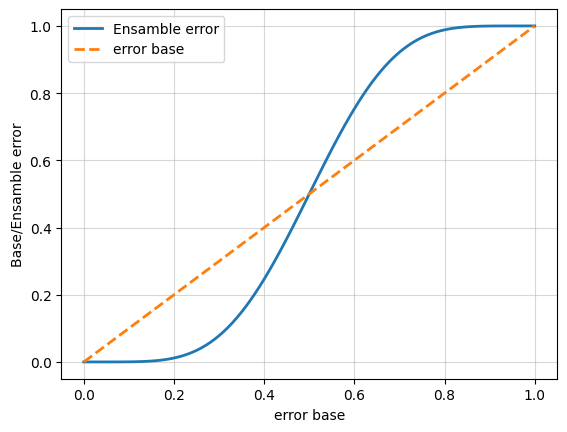

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#rango de errores.
error_range = np.arange(0., 1.01, 0.01)
#error de ensamble
ens_errors = [ensemble_error(n_clasiffier=11, error= error) for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensamble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',
         label='error base', linewidth=2)
plt.xlabel('error base')
plt.ylabel('Base/Ensamble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## Como pudimos observar en el gráfico anterior, la probabilidad del error de un comjunto es siempre mejor que el error de un clasificador básico individual. Siempre y cuando los clasificaores funcionen mejor que la adivinación aleatoria($e$>0.5)  

In [3]:
#para ilustrar el voto mayoritario(Moda)
#utilizaremos argmax y bincount de Numpy
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2,0.6]))

1

## Utilizar la probabilidad de clases para el voto mayoritario puede ser útil si los clasificadores de nuestro conjunto estan bien calibrados. Para utilizar el voto mayoritario ponderado basado en probabilidad de clase, podemos utilizar average y argmax de la libreria NumPy

In [4]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [5]:
!pip install six

## Si juntamos todo implementamos MayorityVoteClassifier en python

In [6]:
! pip install six

In [7]:

from sklearn.base import BaseEstimator, ClassifierMixin, clone
import operator
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.pipeline import _name_estimators

class MayorityVoteClassifier(BaseEstimator, ClassifierMixin):
  """
  un clasificadotr de voto mayoritario
  Parameters
  ------
  classifiers: array-like, shape = [n_classifier]
  different classifiers for the ensemble

  vote : str, {'classlabel', 'Probability'}
    default: 'classlabel'
    if 'classlabel' the prediction is based on the
    argmax of class labels. else if 'probability' ,
    the argmax of the sum of probabilities is used to predict
    the class label(Recommended for calibrated classifiers)

  weights: array-like, shape=[n_classifier]
    optional, default: None
    if a list of 'int' or 'float' values are provided,
    the classsifier are weighted by importance;
    Uses uniform weights if 'weights=None'
    """
  def __init__(self, classifiers, vote="classlabel", weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):

    self.lablenc_= LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else : #voto classlabel
        #Toma los resultados de clf.predict calls
      predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
      maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote

  def predict_proba(self, X):
    probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
    avg_proba = np.average(probas, axis=0, weights=self.weights)
    return avg_proba
  def get_params(self, deep=True):

    if not deep:
      return super(MayorityVoteClassifier, self).get_params(deep=False)
    else:
      out = self.named_classifiers.copy()
      for name, step in six.iteritems(self.named_classifiers):
        for key, value in six.iteritems(step.get_params(deep=True)):
          out['%s__%s'%(name, key)]=value
      return out


In [8]:
"""from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import inspect

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1,
                                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in inspect.signature(step.get_params).parameters.items():
                    out['%s__%s' % (name, key)] = value
            return out
"""

"from sklearn.base import BaseEstimator, ClassifierMixin, clone\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.pipeline import _name_estimators\nimport numpy as np\nimport inspect\n\nclass MajorityVoteClassifier(BaseEstimator, ClassifierMixin):\n    def __init__(self, classifiers, vote='classlabel', weights=None):\n        self.classifiers = classifiers\n        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}\n        self.vote = vote\n        self.weights = weights\n\n    def fit(self, X, y):\n        self.lablenc_ = LabelEncoder()\n        self.lablenc_.fit(y)\n        self.classes_ = self.lablenc_.classes_\n        self.classifiers_ = []\n        for clf in self.classifiers:\n            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))\n            self.classifiers_.append(fitted_clf)\n        return self\n\n    def predict(self, X):\n        if self.vote == 'probability':\n            maj_vote = np.argmax(self.predict_p

In [9]:
#Voto Mayoritario para hacer predicción.
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)


In [10]:
#Dividimos el dataset en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [11]:
#vamos a entrenar 3 clasificadores disitintos con el conjunto de entrenamiento.
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=42)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Regresión logística', 'Árbol de decisiones', 'KNN']
print('10 carpetas de validación cruzada: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('ROC AUC: %0.2f (+/- %0.2f) [%s]'% (scores.mean(), scores.std(),label))

10 carpetas de validación cruzada: 

ROC AUC: 0.95 (+/- 0.11) [Regresión logística]
ROC AUC: 0.97 (+/- 0.07) [Árbol de decisiones]
ROC AUC: 0.88 (+/- 0.10) [KNN]


In [12]:
#Ahora vamos a combinar los clasificadores.
mv_clf = MayorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels+=['Voto mayoritario']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('Precisión: %0.2f (+/- %.2f) [%s]'%(scores.mean(), scores.std(), label))

Precisión: 0.95 (+/- 0.11) [Regresión logística]
Precisión: 0.97 (+/- 0.07) [Árbol de decisiones]
Precisión: 0.88 (+/- 0.10) [KNN]
Precisión: 1.00 (+/- 0.00) [Voto mayoritario]


## Evaluar y ajustar el clasificador conjunto
### Vamos a calcular las curvas ROC a partir de los conjuntos de prueba para comprobar que mayorityVoteClassifier generaliza bien con datos no vistos.

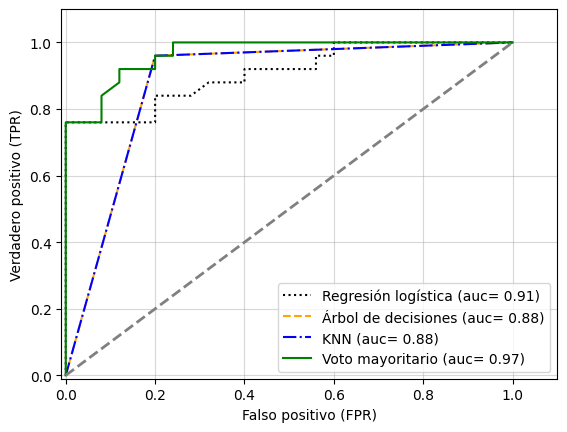

In [13]:
from sklearn.metrics import roc_curve, auc
colors = ['black','orange','blue','green']
linestyle=[':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
  #suponemos que la etiqueta de la clase positiva es 1
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr,tpr, color=clr, linestyle=ls, label='%s (auc= %.2f)'%(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-.01, 1.1])
plt.ylim([-.01, 1.1])
plt.grid(alpha=.5)
plt.xlabel('Falso positivo (FPR)')
plt.ylabel('Verdadero positivo (TPR)')
plt.show()

### Como podemos ver en el ROC resultante el clasificador de voto mayoritario también funciona bien en el conjunto de prueba(ROC AUC = 0.97)

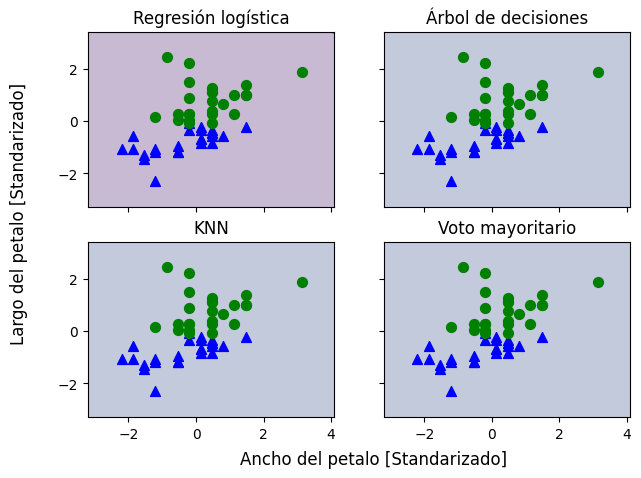

In [14]:
#Vamos a visualizar las regiones de decisión.
sc = StandardScaler()
#Vamos a estandarizar los datos para el árbol de decisión.
X_train_std = sc.fit_transform(X_train)
from itertools import product
X_min = X_train_std[:, 0].min()-1
X_max = X_train_std[:, 0].max()+1
y_min = X_train_std[:, 1].min()-1
y_max = X_train_std[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(X_min, X_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='\nAncho del petalo [Standarizado]', ha='center', va='center', fontsize=12)
plt.text(-14.0, 4.5, s='Largo del petalo [Standarizado]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

### Antes de ajustar los parámetros del clasificador individual para la clasificación conjunta, vamos a llamar al método get_params para obtener una idea de cómo podemos acceder a los parámetros individuales dentro del objeto *GridSearch*:   

In [15]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=42)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=42)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=42),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__cl

### Basándonos en los valores devueltos, ahora sabemos como acceder a los atributos del clasificador individual.

In [16]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2, 3, 4], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, param_grid= params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MayorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=42)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=42),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [17]:
#Vamos a imprimir los mejores hiperparámetros.
#for params, mean_score, scores in grid.cv_results_ :
#  print('%.3f (+/-) %.2f %r'% (mean_score, scores.std()/2, params))
for params, mean_score, scores in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']):
  print('%.3f (+/-) %.2f %r'% (mean_score, scores/2, params))

1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
0.983 (+/-) 0.03 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100.0}
0.983 (+/-) 0.03 {'decisiontreeclassifier__max_depth': 4, 'pipeline-1__clf__C': 0.001}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_depth': 4, 'pipeline-1__clf__C': 0.1}
1.000 (+/-) 0.00 {'decisiontreeclassifier__max_dept

In [18]:
#los mejores prámetros.
print('Los mejores parámetros: %s'% grid.best_params_)

Los mejores parámetros: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [19]:
#Exactitud
print('Exactitud: %.2f' % grid.best_score_)

Exactitud: 1.00


# Bagging: Conjunto de clasificadores a partir de muestrasa bootstrap.
## El funcionamiento del bagging es muy similar al de el voto mayoritario, sin embargo, para ajustar los clasificadores individuales en el conjunto, dibujamos muestras de bootstrap (muestras aleatorias con remplazo) a partir del conjunto de entrenamiento.  

## Bagging para clasificar muestras en el conjunto wine.

In [20]:
import pandas as pd
df_wine= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', ' Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavonoids',
                   'Nonflavonoids phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Propline']

#Elimina clase 1
df_wine = df_wine[df_wine['Class label'] !=1 ]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Scikit-learn cuenta ya con un clasificador bagging implementado que podemos importar del submodulo ensemble.  

In [22]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='log_loss', random_state=42, max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features= False,
                        random_state=42)

In [23]:
#Comprobaremos la precisión del arbol sin podar
#con la precisión del bag
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)
y_train_pred = tree.predict(X_train)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Arbol de decisión train/test exactitud: %.3f / %.3f '% (tree_train, tree_test))

Arbol de decisión train/test exactitud: 1.000 / 0.875 


### El árbol de decisiones sin podar predice correctamente todas las etiquetas de clase de las muestras de entrenamiento, sin embargo, la precisión de la prueba es sustancialmente inferior lo que nos indica la alta varianza(Sobreajuste) del modelo.  

In [24]:
bag = bag.fit(X_train, y_train)
y_test_pred = bag.predict(X_test)
y_train_pred = bag.predict(X_train)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test exactitud: %.3f / %.3f '% (bag_train, bag_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging train/test exactitud: 1.000 / 0.833 


### Vamos a gráficar los límites de decisión.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


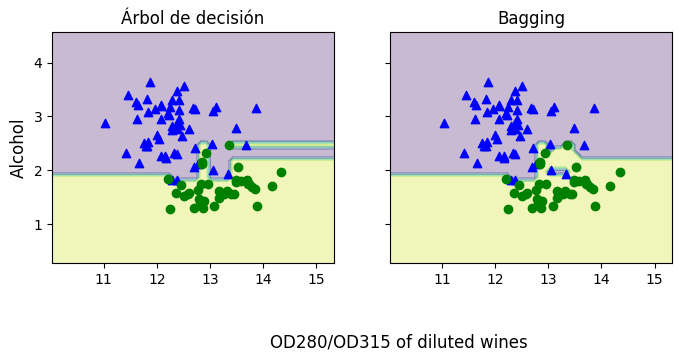

In [25]:
x_min = X_train[:, 0].min()-1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min()-1
y_max = X_train[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0,1], [tree, bag], ['Árbol de decisión', 'Bagging']):
  clf.fit(X_train, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue', marker='^')
  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.show()

### El algoritmo *bagging* puede ser un método efectivo para reducir la varianza de un modelo. Sin embargo, el *bagging* es ineficaz para la reducción del sesgo, es decir, para modelos que son demasido simples como para capturar bien la tendencia de los datos. Esta es la razón por la cual queremos realizar el bagging en un conjunto de clasificadores con sesgo bajo.


## **AdaBoost( Adaptative boosting o Boosting adaptado).**
### En el boosting, el conjunto consiste en unos clasificadores básicos(a menudo denominados **debiles**) que habitualmente solo tiene una leve ventaja sobre la adivinación aleatoria.
### **cómo trabaja el boosting**
1. Dibuja un subconjunto aleatorio de muestras de entrenamiento $d_1$ sin reemplazo a partir del conjunto de entrenamiento $D$ para enternar un clasificador débil $C_1$.
2. Dibja un segundo subconjunto de entrenamiento aletorio $d_2$ sin reemplazo a partir del conjunto de entrenamiento, añadiendo un 50% de las muestras mal clasificadas. Para entrenar un clasificador debil $C_2$.
3. Encontrar las muestras de entrenamiento $d_3$ en el conjunto de entrenamiento $D$, con las cuales $C_1$ y $C_2$ no están de acuerdo, para entrenar un tercer clasificador débil $C_3$.
4. Combinar los clasificadores debiles mediante el voto mayoritario.    

### El *boosting* puede disminuir el sesgo, así como la varianza, comparado con el bagging. Sin embargo, los algoritmos de *boosting* como AdaBoost también son conocidos por su alta varianza, es decir, por su tendencia a el sobreajuste de los datos de entrenamiento.
### En comparación del boosting original, adaboost usa el conjunto de datos completo para entrenar a los clasificadores debiles y crea un clasificador robusto(Basado en el voto mayoritario) que aprende de los errores de los clasificadores debiles anteriores en el conjunto.


## **AdaBoost con scikit-learn**

In [28]:
#Vamos a aplicar Adaboost al conjunto de datos wine
#Que ya preprocesamos.
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=42,
                              max_depth=1)
#Inicializamos AdaBoost con 500 tocones de árbol de decisión.
ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=42)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'árbol de decisiones entrenamiento/test exactitud: {round(tree_train,3)}/{round(tree_test,3)}')

árbol de decisiones entrenamiento/test exactitud: 0.905/0.75


In [29]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost entrenamiento/test exactitud: {round(ada_train,3)}/{round(ada_test,3)}')

AdaBoost entrenamiento/test exactitud: 1.0/0.875


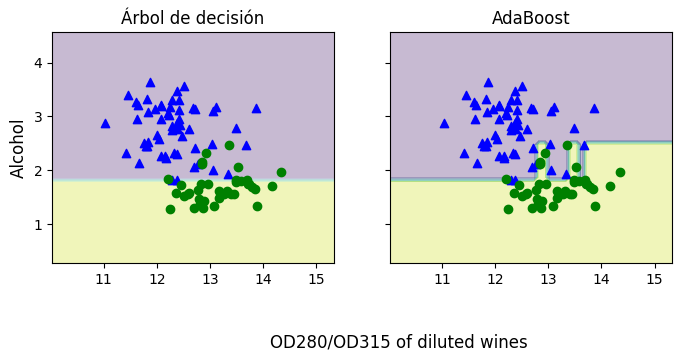

In [30]:
#Vamos a graficar los límites de decisiones.
x_min = X_train[:, 0].min()-1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min()-1
y_max = X_train[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0,1], [tree, ada], ['Árbol de decisión', 'AdaBoost']):
  clf.fit(X_train, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue', marker='^')
  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.show()

### Viendo los límites de decisión del modelo AdaBoost es sustancialmente más complejo que el tocón del árbol de decisión.

### Como aclaración los clasificadores conjuntos aumentan la complejidad computacional en comparación con los clasificadores individuales. En la práctica, tendriamos que pensar que precio queremos pagar por aumentar los costes computacional pra conseguir una mejora relativamente modesta del rendimiento predictivo.